# Description:
Given the rough location of an event, download data for this event for stations meeting a certain epicentral distance criteria.

# Setups

In [3]:
from obspy.clients.fdsn import Client
from obspy.core.event import Origin
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy.io.sac.sactrace import SACTrace
from obspy import read_inventory, UTCDateTime
from obspy import read

import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib notebook

# ***CHANGE THIS*** - things that need to be manually changed for each event

### Choose:

In [4]:
# web service client:
client = Client("IRIS")

# Earth model:
model = TauPyModel(model='iasp91')

# folder for this event:
directory = '/Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/'

# directory to download raw data:
raw_directory = directory+'raw/'

# directory to store instrument-corrected data:
corrected_directory = directory+'corrected/'

%mkdir /Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/
%mkdir /Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/raw/
%mkdir /Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/corrected/

mkdir: /Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/: File exists
mkdir: /Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/raw/: File exists
mkdir: /Users/23brianc/Documents/Internship2020/Events/Wyoming_deep/corrected/: File exists


In [5]:
# pre-filter for removing instrument response:
prefilt = (0.05,0.1,10,20)

def detrend_and_remove_response(stream,window):
    for tr in stream:
        tr.detrend(type='constant')  # de-mean
        tr.detrend(type='linear')
        tr.remove_response(output='VEL',taper = True, taper_fraction = 0.05,pre_filt= window, water_level = 60.0)
    return stream

# Search for stations given an event

In [6]:
# search for stations certain distance away from event
station_search_lower_range=kilometer2degrees(300)  #in km
station_search_upper_range=kilometer2degrees(1100)

In [7]:
# event location: latitude and longitude

evla = 42.975 # ***CHANGE THIS***
evlo = -109.128 # ***CHANGE THIS***

# search timeframe
starttime = UTCDateTime("2013-09-20T13:16:33") # ***CHANGE THIS***
endtime = UTCDateTime("2013-09-22T13:16:33") # ***CHANGE THIS***

# station inventory
inventory = client.get_stations(level='response',channel='BH*',starttime=starttime,endtime=endtime,latitude=evla,
                               longitude=evlo, minradius=station_search_lower_range,
                                maxradius=station_search_upper_range) #network = 'XI'
inventory.write(directory+"inventory.xml",format='STATIONXML')
# inventory[x][y] gives you station y in network x

In [8]:
inventory

Inventory created at 2020-11-10T23:06:36.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2013-09-20...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (23):
			2G, AE, BK, CC, CI, CN, II, IM, IU, IW, LB, LI, MB, PI, PN, SC, TA
			UO, US, UU, UW, X2, Y5
		Stations (165):
			2G.IUGFS (Indiana Univ Geologic Field Station, Cardwell, MT)
			AE.U15A (North Rim, AZ, USA)
			AE.W13A (Hualapai Mountain Park, Kingman, AZ, USA)
			AE.W18A (Petrified Forest, AZ, USA)
			AE.X16A (Lo Mia Camp, Pine, AZ, USA)
			AE.X18A (Snowflake, AZ, USA)
			AE.Y14A (Wickenburg, AZ, USA)
			BK.CMB (Columbia College, Columbia, CA, USA)
			BK.HATC (Hat Creek Radio Astronomy Obs., Cassel, CA, USA)
			BK.HELL (Rademacher Property, Miramonte, CA, USA)
			BK.KCC (Kaiser Creek, CA, USA)
			BK.MOD (Modoc Plateau, CA, USA)
			CC.ASBU (Astronaut Butte)
			CC.CIHL (Cinder Hill, Newberry Volcano)
			CC.CPCO (Central Pumice Co

#### plot a station map if you want to

/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/imaging/maps.py:46: UserWarning: basemap/pyproj with proj4 version >= 5 has a bug that results in inverted map axes. Your maps may be wrong. Please use another version of proj4, or use cartopy. See https://github.com/matplotlib/basemap/issues/443
  warnings.warn(msg)


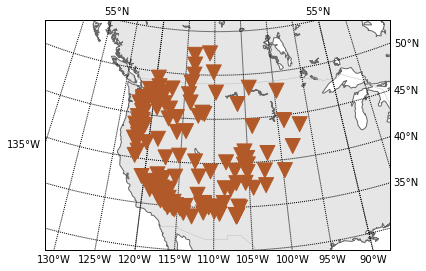

In [9]:
stn_map = inventory.plot(projection="local",show=False)

# Let the computer know the event

In [10]:
event_search_max_radius = kilometer2degrees(200) #in km

In [11]:
catalogue = client.get_events(starttime=starttime,endtime=endtime,latitude=evla,longitude=evlo,
                              maxradius=event_search_max_radius, minmagnitude=4.7,mindepth=60) # ***CHANGE THIS*** mindepth, minmag
print(catalogue)

1 Event(s) in Catalog:
2013-09-21T13:16:32.880000Z | +42.984, -109.038 | 4.8 MW


#### Get event information

In [12]:
event_info = catalogue.events[0].origins[0]
origin_time = event_info.time
evlo = event_info.longitude
evla = event_info.latitude
evdp = event_info.depth

yr = origin_time.year
jd = origin_time.julday
hr = origin_time.hour
mins = origin_time.minute
sec = origin_time.second
msec = origin_time.microsecond

# convert event depth to km if necessary
if evdp > 1000:
    evdp = evdp / 1000

In [16]:
print(catalogue.events[0])

Event:	2013-09-21T13:16:32.880000Z | +42.984, -109.038 | 4.8 MW

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=9219321")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=12138278")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=201984055")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


In [28]:
%store -r common_stations

origin_to_p_deep = []

for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 120
        seconds_after_P = P_arrival_time_at_stn + 1000
        
        for temp in common_stations:
                if temp["stnm"] == (net.code+"."+stn.code):
                    origin_to_p_deep.append(arrival[0].time)
                    

In [29]:
%store origin_to_p_deep

Stored 'origin_to_p_deep' (list)


#### Plot a station-event map if you want to (not working now)

In [19]:
catalogue.plot(fig=stn_map);

<Figure size 432x288 with 0 Axes>

# Loop over each station in each network to request data

In [27]:
for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 120
        seconds_after_P = P_arrival_time_at_stn + 1000
        print(P_arrival_time_at_stn)
        
        try:
            stream = client.get_waveforms(net.code,stn.code,'*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
        except:
            print('No Data'+' for station '+net.code+'.'+stn.code+' !!')
            continue

        number_of_traces = len(stream)
        number_of_locs = int(len(stream)/3)
        print('Found '+str(number_of_traces)+' traces for station '+net.code+'.'+stn.code)
        
        # remove mean, linear trend and instrument response
        try:
            corrected_stream = detrend_and_remove_response(stream,prefilt);
        except Exception as e:
            print('Cannot correct for station '+net.code+'.'+stn.code+' !!'+' due to ', e)
            continue
        
        # write raw data
        for tr in stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = raw_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)
        
        # write corrected data
        for tr in corrected_stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = corrected_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)

2013-09-21T13:17:24.317502Z
Found 3 traces for station 2G.IUGFS
2013-09-21T13:18:12.806297Z
Found 3 traces for station AE.U15A
2013-09-21T13:18:36.310010Z
Found 3 traces for station AE.W13A
2013-09-21T13:18:24.588207Z
No Data for station AE.W18A !!
2013-09-21T13:18:36.642248Z
Found 3 traces for station AE.X16A
2013-09-21T13:18:32.760478Z
Found 3 traces for station AE.X18A
2013-09-21T13:18:47.473244Z
Found 3 traces for station AE.Y14A
2013-09-21T13:18:52.943084Z
Found 3 traces for station BK.CMB
2013-09-21T13:18:46.949198Z
No Data for station BK.HATC !!
2013-09-21T13:18:52.572055Z
No Data for station BK.HELL !!
2013-09-21T13:18:49.311809Z
No Data for station BK.KCC !!
2013-09-21T13:18:31.767754Z
No Data for station BK.MOD !!
2013-09-21T13:18:40.160305Z
Found 3 traces for station CC.ASBU
2013-09-21T13:18:37.974421Z
Found 3 traces for station CC.CIHL
2013-09-21T13:18:38.806002Z
Found 3 traces for station CC.CPCO
2013-09-21T13:18:39.000992Z
Found 3 traces for station CC.NORM
2013-09-21T13:

/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


2013-09-21T13:18:30.051186Z
Found 6 traces for station IU.ANMO
2013-09-21T13:17:29.115770Z
Found 6 traces for station IU.RSSD
2013-09-21T13:17:24.817230Z
Found 3 traces for station IW.DLMT
2013-09-21T13:17:45.100578Z
Found 3 traces for station IW.MFID
2013-09-21T13:17:20.139243Z
Found 3 traces for station IW.PHWY
2013-09-21T13:17:51.361280Z
Found 3 traces for station IW.PLID
2013-09-21T13:17:33.221719Z
Found 3 traces for station IW.SMCO
2013-09-21T13:18:07.636706Z
Found 3 traces for station LB.BMN
2013-09-21T13:18:45.396816Z
Found 3 traces for station LB.DAC
2013-09-21T13:17:46.490044Z
No Data for station LB.MVU !!
2013-09-21T13:18:25.326591Z
No Data for station LB.TPH !!
2013-09-21T13:18:28.553239Z
No Data for station LI.LTH !!
2013-09-21T13:17:59.333973Z
Found 3 traces for station MB.JTMT
2013-09-21T13:18:40.647552Z
No Data for station PI.EP00 !!
2013-09-21T13:18:40.647573Z
No Data for station PI.EP01 !!
2013-09-21T13:18:40.647573Z
No Data for station PI.EP02 !!
2013-09-21T13:18:40.6

In [21]:
type(seconds_before_P)

obspy.core.utcdatetime.UTCDateTime

### Quick preview of downloaded data

In [32]:
raw_st = read(raw_directory+'*')
corrected_st = read(corrected_directory+'*')

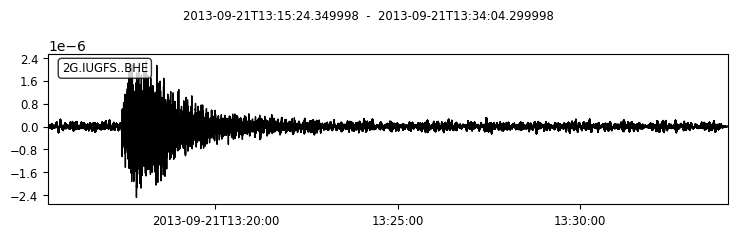

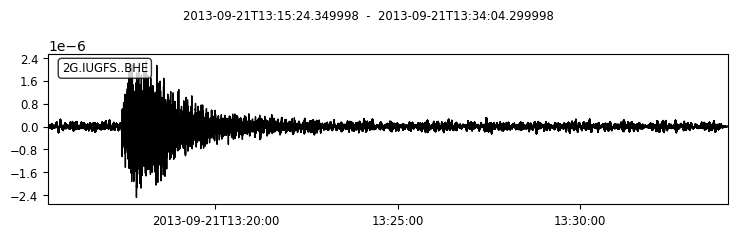

In [33]:
index = 0

raw_st[index].plot();
corrected_st[index].plot();

# Play around with individual case

In [49]:
stn = inventory[6][40]
stla = stn.latitude
stlo = stn.longitude
geo = gps2dist_azimuth(stla,stlo,evla,evlo)
epi_dist = geo[0]/1000. #in km
baz = geo[1]
gcarc = kilometer2degrees(epi_dist) # convert arc length to angle

In [50]:
model = TauPyModel(model='ak135')
arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])

In [51]:
P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
seconds_before_P = P_arrival_time_at_stn - 1000
seconds_after_P = P_arrival_time_at_stn + 2000

In [52]:
try:
    data = client.get_waveforms('G','WUS','*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
except:
    print('No Data!')

number_of_traces = len(data)
number_of_locs = int(len(data)/3)
print('Find '+str(number_of_traces)+' traces for station')  

No Data!


NameError: name 'data' is not defined

In [ ]:
data.plot();

In [ ]:
detrend_and_remove_response(data,prefilt);
data.plot();

In [ ]:
inventory[-1][61]